**Objetivos**
1. Conocer el concepto de escalado de frecuencia como herramienta para resaltar (o enmascarar) regiones específicas en un espectrograma.
2. Aplicar la teoría de diseño de filtros digitales ideales.
3. Aplicar la teoría de diseño de filtros pasa-bajas por el método de enventanado.


# 1. Escalas de espectrogramas

Genere la señal $s(t) = cos(2πf_ot^2)$ con una frecuencia de muestro de 16 kHz y $f_o = 4000 Hz$ con una duración de $t = 3\,\text{seg}$. $s(t)$ corresponde a una señal de frecuencia instántanea creciente de acuerdo con $f_0 t$.

1.1. Grafique el espectrograma de $s(t)$ considernado una escala .lineal de frecuencia y analice el resultado. ¿El comportamiento corresponde a lo esperado?

1.2. ¿Qué ocurre entre $1\text{seg}$ y $3\text{seg}$?

1.3. Grafique el espectrograma  lineal solamente entre 0 y 1s. De aquí en adelante considere solamente este segmento.

1.4. Repita el espectrograma en escalas de frecuencia logarítima y Mel (Las funciones para graficar el espectrograma en cada escala se proveen en esta guía).

1.5. Compare los resultados y analice. ¿Qué frecuencias son enfatizadas en cada caso?

1.6. Repita los gráficos de los espectrogramas en las 3 escalas considerando la señal de audio dada en esta guía.



In [4]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy import signal
from os import listdir
from os.path import isfile, join


In [2]:
def make_spectrograms_all_scales(segm, fs, NFFT, sample_hop, scales = ['linear', 'log', 'mel'], pathFile = 'spectrogram.pdf', ylimmin=0, ylimmax=None, xlimmin=0, xlimmax=None):

  plt.figure(figsize=(5*len(scales),4))
  for i,scale in enumerate(scales):
    stft = np.abs(librosa.stft(segm,  n_fft=NFFT, hop_length=sample_hop))
    if scale == 'mel':

      melfb = librosa.filters.mel(sr=fs, n_fft=NFFT, n_mels=128, fmax=8000)
      stft_mel = np.matmul(melfb, stft)
      plt.subplot(1,len(scales),i+1)
      D = librosa.amplitude_to_db(stft_mel, ref = np.max) # Se convierte la amplitud de lineal a dB
      spec = librosa.display.specshow(D, sr=fs, x_axis='time', y_axis=scale, cmap=None, hop_length=sample_hop)
    else:
      plt.subplot(1,len(scales),i+1)
      D = librosa.amplitude_to_db(stft, ref = np.max) # Se convierte la amplitud de lineal a dB
      spec = librosa.display.specshow(D, sr=fs, x_axis='time', y_axis=scale, cmap=None, hop_length=sample_hop)

    plt.title('Espectrograma ' + scale)
    if ylimmax != None:
      plt.ylim(ylimmin, ylimmax)
    if xlimmax != None:
      plt.xlim(xlimmin, xlimmax)



  plt.savefig(pathFile)
  plt.show()

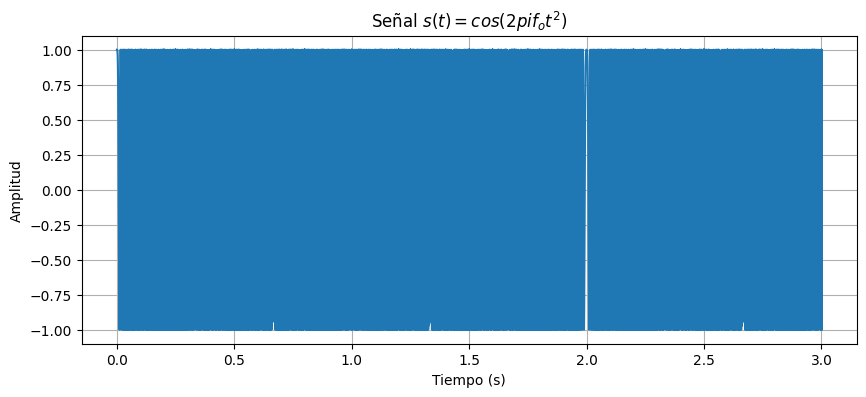

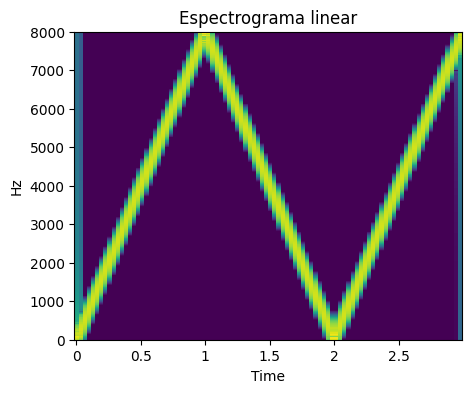

In [6]:
# Parámetros de la señal
def senal(fs=16000, f0=4000, t=3):

    # Generar el vector de tiempo
    t = np.linspace(0, t, int(fs * t), endpoint=False)

    # Generar la señal
    s_t = np.cos(2 * np.pi * f0 * t**2)

    # Visualizar la señal
    plt.figure(figsize=(10, 4))
    plt.plot(t, s_t)
    plt.title("Señal $s(t) = cos(2pi f_o t^2)$")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Amplitud")
    plt.grid()
    plt.show()
    return s_t, fs
    
s_t, fs = senal()

# Parámetros para el espectrograma
NFFT = 2048  # Tamaño de la FFT
sample_hop = 512  # Salto entre ventanas

# Generar el espectrograma en todas las escalas
make_spectrograms_all_scales(s_t, fs, NFFT, sample_hop, scales=['linear'], pathFile='spectrogram_senal.pdf')


# 2. Diseño de filtros digitales

## 2.1. Filtros ideales

**Algunos conceptos teóricos para ilustrar el proceso para diseñar un filtro digital:**


Paso 1. Inicialmente se normalizan las frecuencias de corte, y se pasan a [rad/s] de acuerdo con la expresion:

 $w_c=2\pi \frac{f_c}{f_s}$

Paso 2. Se realiza el mismo procedimiento para el ancho de banda de transición normalizado: $\mathrm{BW}_n= \frac{2\pi \mathrm{BW}}{f_s}$.

Paso 3. Una regla práctica (empírica) para determinar el orden del filtro es dividir 4 por el ancho de banda normalizado y tomar la parte entera del resultado, así: $M=\texttt{int}\left(\frac{4}{\mathrm{BW}_n} \right)$.


Paso 4. Se implementa la respuesta al impulso del filtro ideal de acuerdo con las siguientes ecuaciones:
    

* Pasabajas:
$h_1=\frac{\omega_c}{\pi}S_a(\frac{\omega_c n}{\pi})$
    
* Pasa-altas
$h_2=- \frac{\omega_c}{\pi}S_a(\frac{\omega_c n}{\pi})$

* Pasa-banda
$h_3=\frac{\omega_{c2}}{\pi}S_a(\frac{\omega_{c2} n}{\pi})-\frac{\omega_{c1}}{\pi}S_a(\frac{\omega_{c1} n}{\pi})$

* Rechaza-banda
$h_4=\frac{\omega_{c1}}{\pi}S_a(\frac{\omega_{c1} n}{\pi})-\frac{\omega_{c2}}{\pi}S_a(\frac{\omega_{c2} n}{\pi})$


En el caso de filtros pasa--altas, pasa-banda y rechaza--banda, además de los pasos anteriores, se debe truncar la respuesta en el origen, de la siguiente forma.

* $h1\big|_{n=0}=\frac{w_c}{ \pi}$ cuando es pasa-bajas

* $h2\big|_{n=0} =1-\frac{wc}{\pi}$  cuando es pasa-altas

* $h3\big|_{n=0}=\frac{wc2-wc1}{\pi}$  cuando es pasa-banda

* $h4\big|_{n=0}=1-\frac{wc2-wc1}{\pi}$  cuando es rechaza-banda


Paso 5. Para mitigar el fenómeno de Gibbs se utilizan ventanas (las llamaremos $\text{win(n)}$) diferentes a la rectangular, caracterizadas por no tener cambios abruptos en el dominio del tiempo, lo que conduce a lóbulos de menor amplitud en el dominio de la frecuencia. Algunas ventanas típicas son Hamming, Hanning, Blackman, Triangular, entre otras.
  
Paso 6. Luego se multiplica la respuesta del filtro ideal obtenida ($h(n)$), por la ventana escogida ($h_{\text{new}}(n)=h(n) \mathrm{win(n)}$).

Paso 7. Finalmente se multiplica la respuesta al impulso por la ganancia que se desea para el filtro: $A_{\text{new}}=\sqrt{10^{0.1A_{\text{dB}}}}$
    


2.1.1 Siguiendo el procedimiento indicado arriba cree dos filtros FIR, uno pasabajas y otro pasa altas, con los parámetros indicados abajo. Defina la respuesta del filtro con y sin aplicar la ventana. Para la creación de la ventana utilice la función `scipy.signal.windows` para obtener algunas de las ventanas sugeridas.


```
fc = 1000.0 # Frecuencia de corte
fs = 8000.0 # Frecuencia de muestreo
AdB = 0 # Ganancia del filtro en decibeles
N = 512 # Numero de puntos de la FFT
BW = 500 # Ancho de banda en la banda de transicion
Ventana tipo Hamming
```


2.1.2 Calcule y dibuje la respuesta al impulso en el tiempo $h(n)$ y en frecuencia $H(k)$ para el filtro sin enventanar y envantanando.

Hint: considere la función "scypi.signal.freqz" para calcular la respuesta en frecuencia de los filtros.


## 2.2. Enventanado y tipos de ventana

Utilizando la función `scipy.signal.get_window` genera las siguientes ventanas `'Rectangular', 'Bartlett', 'Hanning', 'Hamming', 'Blackman'`. Realice la gráfica de las ventanas y de la respuesta en frecuencia de cada una. Compare los resultados y realice el análisis en términos de la resolución en frecuencia y la potencia de los lóbulos secundarios de la respuesta en frecuencia.

**Incluir subplot con: pasabajas, pasabanda, y pasaalta. Pudiendo jugar con diferentes ventanas.**

## 2.3. Análisis del orden de los filtros no ideales

Utilice la función `scipy.signal.firwin` para crear un filtro especificando con una ventana de Hamming `window='hamming'`. Grafique la respuesta en frequencia del filtro variando el orden de éste así: `[10, 30, 100]`.

## 3 Aplicación de un filtro a una señal de audio contaminada con ruido
La señal "señal_ruidosa.wav" ha sido afectada por AWGN (Ruido Blanco Aditivo Gaussiano).

* Genere filtros pasabandas de orden 20 entre las frecuencias 100Hz y 3400Hz. Utilice tanto una ventana rectangular como una ventana de Hamming.
* Aplique ambos filtros a la señal ruidosa. Reproduzca tanto el audio original, como los resultados del filtrado usando las ventanas rectangular y Hamming.
* Grafique los espectrogramas tanto del audio original, como los resultados del filtrado usando las ventanas rectangular y Hamming. Analice los resultados


# 4 Diseño de un filtro

Diseñe su filtro FIR pasabandas con el mı́nimo orden posible cumpliendo con las especificaciones asignadas.

*   Máximo orden del filtro: 22
*   $f_1 = 1 kHz $, $f_2 =5$kHz
*   Máximo banda de transición = 110 Hz
*   Máximo rizado de la banda pasante: 0.118
*   Máximo rizado de la banda de rechazo: 0.002

Considere que el filtro esta en la banda pasante cuando la ganancia sea mayor a -1 dB y se encuentra en la banda de rechazo cuando la ganancia sea inferior a -10dB

Construya dos versiones de la figura, una donde el eje horizontal tenga valores de frecuencia normalizada y otra con valores en Hertz. Use una frecuencia de muestreo que permita visualizar correctamente el comportamiento del filtro. Procure que la banda pasante esté cercana al centro de la figura.



A continuación se presenta una figura que ilustra los criterios mencionados arriba para el caso de un
filtro pasabajas:

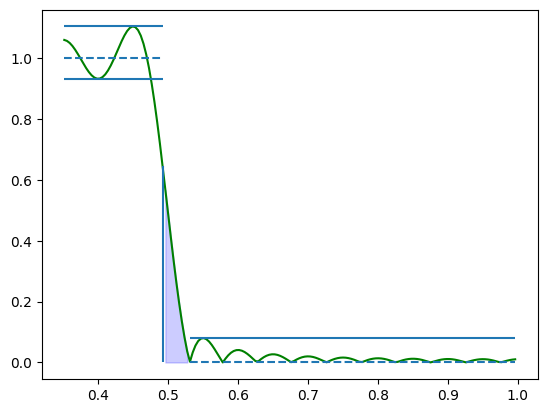